<img src='letscodebr_cover.jpeg' align='left' width=100%/>

# Ada Tech [DS-PY-004] Técnicas de Programação I (PY) Aulas 4 e 5 : GeoPandas - Resolução do Exercício 6.

## Conjuntos de dados

Na prática de aula de hoje, usaremos um **conjunto de propriedades** que a imobiliária [Properati](https://www.properati.com.ar/) tem à venda. O interessante é que aos dados clássicos da propriedade (valor, superfície, vizinhança, tipo de propriedade), adiciona-se a posição geoespacial através de sua latitude e longitude.

Por outro lado, vamos considerar as **estações de metrô**, onde também aparecem o nome e a linha a que pertence, e também, obviamente, seus dados de posição geográfica.

## Exercício

Começamos lendo os dois conjuntos de dados em um `dataframe` e os transformamos em um `GeoDataFrame`. É o tipo de dado que o `GeoPandas` necessita para realizar operações com dados geoespaciais.

Então vamos calcular a distância de cada propriedade até o obelisco de Buenos Aires, e isso será registrado em uma nova coluna. Faremos um cálculo para ver se existe alguma relação entre essa distância e o preço do imóvel.

Finalmente desenharemos uma linha geométrica com todas as estações de metrô de uma linha, e faremos um gráfico sobre a cidade.

Importamos as bibliotecas de que vamos precisar:

In [52]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import shapely # gera as figuras geométricas
import descartes # relacionar-se bem com matplotlib
import pyproj # projeções. Transformação de Coordenadas

### Parte 1 - Arquivo de Propriedades

Vamos ler os dados do arquivo "../Data/Real_State_Properati.csv" em um `DataFrame` do pandas com o método [`pandas.read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), instanciando o objeto `df_prop`.

**Nota**: os dados são separados por tabulações. O parâmetro [`sep = '\ t'`](https://www.ti-enxame.com/pt/python/o-que-impressao-...-sep-t-significa/1045309866/) deve ser usado.

In [53]:
data_location = "../Data/Real_State_Properati.csv"

df_prop = pd.read_csv(data_location, 
                      sep = '\t' 
                     )

- 1.a. Tomamos uma amostra de 5 elementos.

In [54]:
# 1.a
df_prop.sample(5)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
11950,apartment,Palermo,Argentina,Capital Federal,-34.576346,-58.424262,248000.0,USD,64.0
11569,apartment,Villa Crespo,Argentina,Capital Federal,-34.603666,-58.440697,92500.0,USD,44.0
12735,store,Palermo,Argentina,Capital Federal,-34.578598,-58.435553,620000.0,USD,283.0
13017,apartment,Recoleta,Argentina,Capital Federal,-34.590930,-58.386928,95000.0,USD,22.0
15413,apartment,Palermo Soho,Argentina,Capital Federal,-34.590135,-58.432098,343000.0,USD,122.0


- 1 b. Quantas propriedades existem? Quantas são as colunas?

In [55]:
# 1.b
df_prop.shape

(17223, 9)

- 1 C. Quais são as colunas? Que tipo de dados elas têm?

In [56]:
# 1.c
df_prop.dtypes

property_type           object
place_name              object
country_name            object
state_name              object
lat                    float64
lon                    float64
price                  float64
currency                object
surface_total_in_m2    float64
dtype: object

In [57]:
# 1.c. Otra
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17223 entries, 0 to 17222
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        17223 non-null  object 
 1   place_name           17223 non-null  object 
 2   country_name         17223 non-null  object 
 3   state_name           17223 non-null  object 
 4   lat                  17223 non-null  float64
 5   lon                  17223 non-null  float64
 6   price                17223 non-null  float64
 7   currency             17223 non-null  object 
 8   surface_total_in_m2  17223 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.2+ MB


- 1.d. Quantas propriedades existem por bairro? A vizinhança está listada na coluna `place_name`.

Dica: Você pode aplicar o método [`pandas.Series.value_counts()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html?highlight=value_counts#pandas.Series.value_counts).

In [58]:
# 1.d.
bairros = df_prop["place_name"]
bairros.value_counts()

place_name
Palermo            1502
Belgrano           1496
Caballito          1389
Recoleta           1001
Flores              893
                   ... 
Parque Chas          15
Palermo Viejo        10
Villa Soldati         7
Villa Riachuelo       3
Catalinas             1
Name: count, Length: 62, dtype: int64

In [59]:
# 1.d. Outra forma
grouped = df_prop['price'].groupby(df_prop['place_name'])
grouped.count()

place_name
Abasto               59
Agronomía            25
Almagro             755
Balvanera           426
Barracas            309
                   ... 
Villa Riachuelo       3
Villa Santa Rita     26
Villa Soldati         7
Villa Urquiza       774
Villa del Parque    215
Name: price, Length: 62, dtype: int64

In [60]:
# 1.d. Outra forma parecida
df_prop.groupby(['place_name'])[['price']].count()

,price
place_name,
Abasto,59
Agronomía,25
Almagro,755
Balvanera,426
Barracas,309
...,...
Villa Riachuelo,3
Villa Santa Rita,26
Villa Soldati,7


- 1.e. As colunas `lat` e `lon` identificam a latitude e longitude da posição geoespacial das propriedades. Mas precisamos que a posição seja expressa pela forma geométrica Point, para podermos trabalhá-la a partir do GeoPandas.

Em outras palavras, devemos transformar o `DataFrame` em um `GeoDataFrame`. Vamos instanciar o objeto `geo_prop`. Mas para gerar um `GeoDataFrame`, precisamos adicionar uma nova coluna contendo uma forma geométrica às colunas do `DataFrame`. Nesse caso, um `ponto`, que é gerado a partir de latitude e longitude. Recomenda-se que a nova coluna seja nomeada `geometry`. Fazemos isso com o método [`geopandas.points_from_xy()`](https://geopandas.org/docs/reference/api/geopandas.points_from_xy.html).

*Observe* que para definir o tipo *ponto*, inserimos a **longitude** e a **latitude**.

In [61]:
# 1.e
geometria = gpd.points_from_xy(df_prop['lon'], 
                               df_prop['lat']
                              )
geo_prop = gpd.GeoDataFrame(df_prop, 
                            geometry = geometria
                           )

In [62]:
# 1.e. Outra forma
geo_prop1 = gpd.GeoDataFrame(df_prop, 
                             geometry = gpd.points_from_xy(df_prop.lon, 
                                                          df_prop.lat
                                                         )
                            )

Verificamos a nova coluna observando as primeiras linhas.

In [63]:
# 1.e
geo_prop.loc[:4, ['geometry', 'lat', 'lon','property_type','place_name']]

,geometry,lat,lon,property_type,place_name
0,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos


### Parte 2 - Arquivo da estação de metrô

Vamos ler os dados do arquivo "../Data/estaciones-de-subte.csv" em um `DataFrame` do pandas com o método [`pandas.read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). Vamos instanciar o objeto `df_subte`.

**Nota**: Os dados são separados por vírgulas. O parâmetro `sep = ','` deve ser usado.

In [64]:
data_location = "../Data/metro-BA.csv"

df_subte = pd.read_csv(data_location, sep = ',')

- 2.a. Consultamos os primeiros $10$ registros.

In [65]:
#2.a.
df_subte.head(10)

,lon,lat,id,est,lin
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H
3,-58.404732,-34.615242,4.0,VENEZUELA,H
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H
5,-58.380574,-34.604245,6.0,9 DE JULIO,D
6,-58.397924,-34.599757,7.0,FACULTAD DE MEDICINA,D
7,-58.385142,-34.601587,8.0,TRIBUNALES - TEATRO COLÓN,D
8,-58.407161,-34.591628,9.0,AGÜERO,D
9,-58.415955,-34.585156,10.0,R.SCALABRINI ORTIZ,D


- 2.b. Quantas estações existem? Quantas são as colunas?

In [66]:
# 2.b.
print("estações: " + str(df_subte.shape[0]))
print("colunas: " + str(df_subte.shape[1]))

estações: 90
colunas: 5


- 2 c. Quais são as colunas? Que tipo de dados são eles?

In [67]:
# 2.c.
df_subte.dtypes

lon    float64
lat    float64
id     float64
est     object
lin     object
dtype: object

- 2.d. Quantas estações temos por linha?

Dica: Similar ao punto 1.d

In [68]:
# 2.d.
lineas = df_subte["lin"]
lineas.value_counts()

lin
A    18
E    18
B    17
D    16
H    12
C     9
Name: count, dtype: int64

In [69]:
# 2.d. Outra forma
grouped = df_subte['id'].groupby(df_subte['lin'])
grouped.count()

lin
A    18
B    17
C     9
D    16
E    18
H    12
Name: id, dtype: int64

In [70]:
# 2.d. Outra forma parecida
df_subte.groupby(['lin'])[['id']].count()

,id
lin,
A,18
B,17
C,9
D,16
E,18
H,12


- 2.e. As colunas `lat` e `lon` identificam a latitude e a longitude da posição geoespacial das propriedades. Mas precisamos que a posição seja expressa pela forma geométrica `Point`, para podermos trabalhá-la a partir do `GeoPandas`.

Dica: Similar ao punto 1.e

In [71]:
# 2.e.
geo_subte = gpd.GeoDataFrame(df_subte, 
                             geometry = gpd.points_from_xy(df_subte['lon'], 
                                                           df_subte['lat']
                                                          )
                            )

Verificamos a nova coluna observando as primeiras linhas.

In [72]:
geo_subte.head(5)

,lon,lat,id,est,lin,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)


### Parte 3 - Cálculo da distância

Vamos calcular a distância de cada propriedade ao obelisco de Buenos Aires, e a registraremos em uma nova coluna.

Primeiro, precisamos representar a localização geográfica do Obelisco de Buenos Aires. Fazemos isso usando a forma geométrica `Point` e as coordenadas do lugar.

In [73]:
from shapely.geometry import Point

point_obelisk_p = Point(-58.381555, -34.605425)

In [74]:
type(point_obelisk_p)

shapely.geometry.point.Point

Já o método que calcula a distância entre dois pontos, [`geopy.distance.geodesic()`](https://geopy.readthedocs.io/en/stable/#geopy.distance.geodesic), precisa representar a localização geográfica do Obelisco de Buenos Aires por uma tupla.

In [75]:
point_obelisk = (-58.381555,-34.605425)

In [76]:
type(point_obelisk)

tuple

Agora podemos adicionar a nova coluna com a distância entre o ponto do obelisco e o ponto de cada propriedade (em metros). Vamos chamá-lo de `obelisk_distance`.

**Uma iteração** deve ser gerada no índice de `geo_prop`:

Dica: Você pode explorar o código

```python
for i in geo_prop.index:
    geo_prop.loc[i, 'distance_obelisk'] = Cálculo da distância entre o obelisco e cada propriedade.
```
    
O [cálculo da distância](https://geopy.readthedocs.io/en/stable/#module-geopy.distance) é realizado com o método [`geopy.distance.geodesic()`](https://geopy.readthedocs.io/en/stable/#geopy.distance.geodesic), discutido. Também com a instrução: 

```python
geo_prop.loc[i, 'geometry'].X 
```
obtemos a coordenada de comprimento da distância. Deve terminar com `.meters` para indicar a distância em metros.

In [77]:
# 3.a
import geopy.distance

for i in geo_prop.index:
    geo_prop.loc[i, 'distance_obelisk'] = geopy.distance.geodesic(point_obelisk,
                  (geo_prop.loc[i,'geometry'].x
                  ,geo_prop.loc[i,'geometry'].y)).meters

Verificamos a nova coluna observando as primeiras linhas.

In [78]:
geo_prop.loc[ : 4, ['distance_obelisk', 'geometry', 'lat', 'lon', 'property_type', 'place_name']]

,distance_obelisk,geometry,lat,lon,property_type,place_name
0,14555.078219,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,15988.570648,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,7381.316759,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,7381.316759,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,13651.907067,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos


Vamos calcular a relação entre a distância até o obelisco e os preços de cada propriedade. Calcularemos também a média por vizinhança da distância e dos preços, e então classificaremos as médias e ver se os primeiros $10$ classificados de cada média são das mesmas barras.

Para todos os cálculos, precisamos usar o método `groupby`. Primeiro, um novo `GeoDataFrame` deve ser criado com tantas linhas quanto vizinhanças.

In [79]:
geo_prop_group = geo_prop.groupby(['place_name']).count()

In [80]:
type(geo_prop_group)

pandas.core.frame.DataFrame

In [81]:
geo_prop_group

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distance_obelisk
place_name,,,,,,,,,,
Abasto,59,59,59,59,59,59,59,59,59,59
Agronomía,25,25,25,25,25,25,25,25,25,25
Almagro,755,755,755,755,755,755,755,755,755,755
Balvanera,426,426,426,426,426,426,426,426,426,426
Barracas,309,309,309,309,309,309,309,309,309,309
...,...,...,...,...,...,...,...,...,...,...
Villa Riachuelo,3,3,3,3,3,3,3,3,3,3
Villa Santa Rita,26,26,26,26,26,26,26,26,26,26
Villa Soldati,7,7,7,7,7,7,7,7,7,7


Em seguida, devemos adicionar duas colunas com as médias (distância e preço) por bairro.


Dica:
```python
geo_prop_group['nova coluna'] = geo_prop.groupby(['xxxxxxx'])[["yyyy"]].mean()
```

In [82]:
# 3.b. Preços médios por bairro
geo_prop_group['price']  =  geo_prop.groupby(['place_name'])[['price']].mean()

In [83]:
# 3.b. Distância média por bairro
geo_prop_group['distance'] =  geo_prop.groupby(['place_name'])[['distance_obelisk']].mean()

E por último, acrescente mais duas colunas com a classificação de acordo com a média (distância e preço) por bairro.

Dica:
```python
geo_prop_group["nova coluna rank"] = geo_prop_group['xxxxxxxx'].rank(ascending = True)
```

In [84]:
# 3.b.Ranking distância por bairro
geo_prop_group["rank_distance"] = geo_prop_group['distance'].rank(ascending = True)

In [85]:
# 3.b.Ranking preço por bairro

geo_prop_group["rank_price"] = geo_prop_group['price'].rank(ascending = False)

Nós verificamos as novas colunas.

In [86]:
geo_prop_group.loc[:, ['price','distance','rank_distance','rank_price']]

,price,distance,rank_distance,rank_price
place_name,,,,
Abasto,1.792157e+05,3366.178150,19.0,49.0
Agronomía,1.597952e+05,11496.658313,50.0,56.0
Almagro,2.383719e+05,4487.683052,23.0,24.0
Balvanera,1.667908e+05,2428.895604,15.0,53.0
Barracas,1.924282e+05,2152.119311,11.0,43.0
...,...,...,...,...
Villa Riachuelo,1.833333e+05,11034.007945,46.0,48.0
Villa Santa Rita,2.113846e+05,10786.585585,44.0,34.0
Villa Soldati,1.310730e+06,7454.006046,34.0,1.0


Finalmente, observe se os primeiros $10$ classificados de cada média são das mesmas bairros. Faça primeiro na classificação de distância e, em seguida, na classificação de preços.

Dica: Você pode aplicar o modelo [pandas.DataFrame.sort_values](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.sort_values.html).

In [87]:
# 10 primeros rankeados por distance
geo_prop_group.sort_values(by = "rank_distance").head(10)

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distance_obelisk,distance,rank_distance,rank_price
place_name,,,,,,,,,,,,,
Catalinas,1,1,1,1,1,550000.000000,1,1,1,1,634.212781,1.0,6.0
Centro / Microcentro,190,190,190,190,190,237368.142105,190,190,190,190,680.202508,2.0,25.0
San Nicolás,118,118,118,118,118,190561.237288,118,118,118,118,693.926823,3.0,45.0
Tribunales,65,65,65,65,65,198811.830769,65,65,65,65,836.603422,4.0,37.0
Retiro,141,141,141,141,141,412255.000000,141,141,141,141,839.671966,5.0,11.0
Monserrat,265,265,265,265,265,199876.535849,265,265,265,265,888.232530,6.0,35.0
Constitución,154,154,154,154,154,164743.538961,154,154,154,154,1236.226130,7.0,54.0
San Telmo,573,573,573,573,573,506590.057592,573,573,573,573,1280.499050,8.0,7.0
Congreso,174,174,174,174,174,153215.413793,174,174,174,174,1382.937608,9.0,59.0


In [88]:
# 10 primeros rankeados por price
geo_prop_group.sort_values(by = "rank_price").head(10)

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distance_obelisk,distance,rank_distance,rank_price
place_name,,,,,,,,,,,,,
Villa Soldati,7,7,7,7,7,1.310730e+06,7,7,7,7,7454.006046,34.0,1.0
Nuñez,384,384,384,384,384,1.164123e+06,384,384,384,384,9772.556382,41.0,2.0
Palermo Chico,146,146,146,146,146,1.100355e+06,146,146,146,146,3689.581743,20.0,3.0
Puerto Madero,364,364,364,364,364,9.774262e+05,364,364,364,364,2234.361297,12.0,4.0
Belgrano,1496,1496,1496,1496,1496,5.778869e+05,1496,1496,1496,1496,8403.113119,37.0,5.0
Catalinas,1,1,1,1,1,5.500000e+05,1,1,1,1,634.212781,1.0,6.0
San Telmo,573,573,573,573,573,5.065901e+05,573,573,573,573,1280.499050,8.0,7.0
Recoleta,1001,1001,1001,1001,1001,5.062143e+05,1001,1001,1001,1001,1779.484055,10.0,8.0
Boedo,278,278,278,278,278,4.437263e+05,278,278,278,278,4146.008502,22.0,9.0


### Parte 4 - Linha conectando às estações de metrô

Vamos fazer uma linha geométrica com as estações de metrô da linha H e representá-la graficamente sobre a cidade.

<div>
    <div class = "mapa">
        <img src='img/metro_BA.jpg' alt="Elementos geométricos" width=80% height=90%>
    </div>
</div>

In [89]:
geo_subte.head(4)

,lon,lat,id,est,lin,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)


Primeiro vamos selecionar apenas as estações na linha H, e salvar a seleção na variável `geo_subte_h`.

In [90]:
geo_subte_h = geo_subte.loc[geo_subte['lin'] == 'H', :]

In [91]:
geo_subte_h

,lon,lat,id,est,lin,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)
76,-58.405450,-34.604490,77.0,CORRIENTES,H,POINT (-58.40545 -34.60449)
77,-58.405795,-34.638406,78.0,PARQUE PATRICIOS,H,POINT (-58.40579 -34.63841)
78,-58.412385,-34.641269,79.0,HOSPITALES,H,POINT (-58.41239 -34.64127)
83,-58.403721,-34.598455,84.0,CÓRDOBA,H,POINT (-58.40372 -34.59846)
84,-58.397216,-34.587462,85.0,LAS HERAS,H,POINT (-58.39722 -34.58746)


Como mostra o desenho, a linha vai de Norte a Sul (ou Sul a Norte). Como as estações devem estar alinhadas para que a linha saia corretamente, podemos usar a coluna `lat` para ordená-las; `lat` é a latitude de cada estação.

Dica: Considere aplicar o método [`pandas.DataFrame.sort_values()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)

In [92]:
geo_subte_h = geo_subte_h.sort_values(by = 'lat')

In [93]:
geo_subte_h

,lon,lat,id,est,lin,geometry
78,-58.412385,-34.641269,79.0,HOSPITALES,H,POINT (-58.41239 -34.64127)
77,-58.405795,-34.638406,78.0,PARQUE PATRICIOS,H,POINT (-58.40579 -34.63841)
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)
76,-58.405450,-34.604490,77.0,CORRIENTES,H,POINT (-58.40545 -34.60449)
83,-58.403721,-34.598455,84.0,CÓRDOBA,H,POINT (-58.40372 -34.59846)
85,-58.402376,-34.594525,86.0,SANTA FE - CARLOS JAUREGUI,H,POINT (-58.40238 -34.59453)


Para simplificar a codificação, manteremos apenas os dados geográficos de cada estação. Geramos uma `GeoSeries` com a coluna geométrica de `geo_subte_h`. E nós o chamamos de `geo_subte_h_geometry`.

In [94]:
geo_subte_h_geometry = geo_subte_h["geometry"]

In [95]:
type(geo_subte_h_geometry)

geopandas.geoseries.GeoSeries

Agora criamos as linhas que conectam as estações de metrô. Cada linha é formada por dois pontos. Portanto, temos que pegar o primeiro e o segundo pontos da `Geoserie` e aplicar o método [`shapely.geometry.LineString()`](https://autogis-site.readthedocs.io/en/latest/notebooks/L1/geometric-objects.html#linestring) a eles. Em seguida, continuamos com o segundo e o terceiro, e assim por diante.

Primeiro criamos uma lista onde salvaremos cada linha. Chamamos de `line_h`. Deve ter comprimento igual ao número de estações menos $1$, ou seja, comprimento $11$.

In [96]:
longitud_line = len(geo_subte_h_geometry) - 1
line_h = list(range(longitud_line))

In [97]:
len(line_h)

11

Agora podemos criar as linhas e salvá-las na lista.

**Uma iteração** deve ser gerada para atravessar a `GeoSerie` `geo_subte_h_geometry`.

Dica: Considere aplicar o seguinte código

```python
for i in range(longitud_line): 
    line_h[i] = Linha criada entre o elemento i e o elemento i + 1
```

O cálculo é realizado com o método [`shapely.geometry.LineString()`](https://autogis-site.readthedocs.io/en/latest/notebooks/L1/geometric-objects.html#linestring) da biblioteca `shapely`, discutido anteriormente.

In [98]:
from shapely.geometry import LineString

for i in range(longitud_line): 
    line_h[i] = LineString([geo_subte_h_geometry.iloc[i], 
                            geo_subte_h_geometry.iloc[i + 1]
                           ]
                          )

Agora vamos representar graficamente as linhas num mapa com os bairros de Buenos Aires. Vamos ler os dados do arquivo "../Data/Neighborhoods.csv" em um `DataFrame` do pandas com o método [`pandas.read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). Vamos instanciar o objeto `df_bairros`.

In [99]:
df_bairros = pd.read_csv("../Data/Neighborhoods.csv", encoding = 'latin1')

E então geramos um `GeoDataFrame` dos bairros a partir do `Dataframe`. Neste caso, a coluna `WKT` já contém uma forma geométrica polígono que representa o contorno de cada vizinhança. Mas em um formato `WKT`, não permite gerar um `GeoDataFrame`. Portanto, temos que convertê-lo em um formato de `geometria`.

In [100]:
import shapely.wkt

df_bairros["WKT"] = df_bairros["WKT"].apply(shapely.wkt.loads) 
geo_bairros = gpd.GeoDataFrame(df_bairros, 
                               geometry = 'WKT')

Por outro lado, precisamos representar graficamente as linhas para gerar uma `Geoserie` onde cada elemento é composto por dois pontos e a linha entre eles.

In [101]:
line_h_geo = list(range(longitud_line))

for i in range(longitud_line): 
    line_h_geo[i] = gpd.GeoSeries([geo_subte_h_geometry.iloc[i], 
                                   geo_subte_h_geometry.iloc[i + 1], 
                                   line_h[i] 
                                  ]
                                 )

Com o método `plot()`, geramos o gráfico:

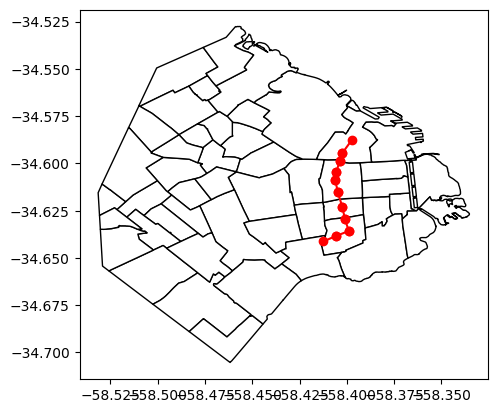

In [102]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

geo_bairros.plot(ax = ax, 
                 color = 'white', 
                 edgecolor = 'black'
                )

for i in range(len(geo_subte_h_geometry) - 2):     
    line_h_geo[i].plot(ax = ax, 
                       color = 'red'
                      )

plt.show();